In [1]:
!nvidia-smi 

Sat Apr 29 03:10:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Python/DataBearing'


Mounted at /content/drive
/content/drive/MyDrive/Python/DataBearing


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import utils
import time
import utils_lenet5
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#from keras.backend.tensorflow_backend import set_session
from keras.backend import set_session
import tensorflow as tf
# set the memory usage
tf_config = tf.compat.v1.ConfigProto()
tf_config.gpu_options.allow_growth = True
set_session(tf.compat.v1.Session(config=tf_config))
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np
import imp
from IPython.display import clear_output
import pandas as pd
bs = 16
is_spectrogram = True


#Data loader

In [4]:
training_samples = 90
split = training_samples//30


In [5]:
import os,re
import errno
import random
import urllib.request as urllib
import numpy as np
from scipy.io import loadmat
from sklearn.utils import shuffle

def fliter_key(keys):
    fkeys = []
    for key in keys:
        matchObj = re.match( r'(.*)FE_time', key, re.M|re.I)
        if matchObj:
            fkeys.append(matchObj.group(1))
    if(len(fkeys)>1):
        print(keys)
    return fkeys[0]+'DE_time',fkeys[0]+'FE_time'


exps_idx = {
    '12DriveEndFault':0,
    '12FanEndFault':9,
    '48DriveEndFault':0
}

faults_idx = {
    'Normal': 0,
    '0.007-Ball': 1,
    '0.014-Ball': 2,
    '0.021-Ball': 3,
    '0.007-InnerRace': 4,
    '0.014-InnerRace': 5,
    '0.021-InnerRace': 6,
    '0.007-OuterRace6': 7,
    '0.014-OuterRace6': 8,
    '0.021-OuterRace6': 9,
#     '0.007-OuterRace3': 10,
#     '0.014-OuterRace3': 11,
#     '0.021-OuterRace3': 12,
#     '0.007-OuterRace12': 13,
#     '0.014-OuterRace12': 14,
#     '0.021-OuterRace12': 15,
}

def get_class(exp,fault):
    if fault == 'Normal':
        return 0
    return exps_idx[exp] + faults_idx[fault]
    
 
class CWRU:
    def __init__(self, exps, rpms, length):
        for exp in exps:
            if exp not in ('12DriveEndFault', '12FanEndFault', '48DriveEndFault'):
                print("wrong experiment name: {}".format(exp))
                return
        for rpm in rpms:    
            if rpm not in ('1797', '1772', '1750', '1730'):
                print("wrong rpm value: {}".format(rpm))
                return
        # root directory of all data
        rdir = os.path.join('Datasets/CWRU')
        print(rdir,exp,rpm)
 
        fmeta = os.path.join(os.path.dirname('__file__'), 'metadata.txt')
        all_lines = open(fmeta).readlines()
        all_lines = open(fmeta).readlines()
        lines = []
        for line in all_lines:
            l = line.split()
            if (l[0] in exps or l[0] == 'NormalBaseline') and l[1] in rpms:
                if 'Normal' in l[2] or '0.007' in l[2] or '0.014' in l[2] or '0.021' in l[2]:
                    if faults_idx.get(l[2],-1)!=-1:
                        lines.append(l)
 
        self.length = length  # sequence length
        lines = sorted(lines, key=lambda line: get_class(line[0],line[2])) 
        self._load_and_slice_data(rdir, lines)
        # shuffle training and test arrays
        self._shuffle()
        self.all_labels = tuple(((line[0]+line[2]),get_class(line[0],line[2])) for line in lines)
        self.classes = sorted(list(set(self.all_labels)), key=lambda label: label[1]) 
        self.nclasses = len(self.classes)  # number of classes
 
    def _mkdir(self, path):
        try:
            os.makedirs(path)
        except OSError as exc:
            if exc.errno == errno.EEXIST and os.path.isdir(path):
                pass
            else:
                print("can't create directory '{}''".format(path))
                exit(1)
 
    def _download(self, fpath, link):
        print(link + " Downloading to: '{}'".format(fpath))
        urllib.urlretrieve(link, fpath)
        
    def _load_and_slice_data(self, rdir, infos):
        self.X_train = np.zeros((0, self.length, 2))
        self.X_test = np.zeros((0, self.length, 2))
        self.y_train = []
        self.y_test = []
        train_cuts = list(range(0,60000,80))[:split]
        test_cuts = list(range(60000,120000,self.length))[:25]
        for idx, info in enumerate(infos):
 
            # directory of this file
            fdir = os.path.join(rdir, info[0], info[1])
            self._mkdir(fdir)
            fpath = os.path.join(fdir, info[2] + '.mat')
            print(idx,fpath)
            if not os.path.exists(fpath):
                self._download(fpath, info[3].rstrip('\n'))
 
            mat_dict = loadmat(fpath)
            key1,key2 = fliter_key(mat_dict.keys())
            time_series = np.hstack((mat_dict[key1], mat_dict[key2]))
            idx_last = -(time_series.shape[0] % self.length)
            
            print(time_series.shape)
            
            clips = np.zeros((0, 2))
            for cut in shuffle(train_cuts):
                clips = np.vstack((clips, time_series[cut:cut+self.length]))
            clips = clips.reshape(-1, self.length,2)
            self.X_train = np.vstack((self.X_train, clips))
            
            clips = np.zeros((0, 2))
            for cut in shuffle(test_cuts):
                clips = np.vstack((clips, time_series[cut:cut+self.length]))
            clips = clips.reshape(-1, self.length,2)
            self.X_test = np.vstack((self.X_test, clips))
            
            self.y_train += [get_class(info[0],info[2])] * split
            self.y_test += [get_class(info[0],info[2])] * 25
            
        self.X_train.reshape(-1, self.length,2)  
        self.X_test.reshape(-1, self.length,2) 
 
    def _shuffle(self):
        # shuffle training samples
        index = list(range(self.X_train.shape[0]))
        random.Random(0).shuffle(index)
        self.X_train = self.X_train[index]
        self.y_train = np.array(tuple(self.y_train[i] for i in index))
 
        # shuffle test samples
        index = list(range(self.X_test.shape[0]))
        random.Random(0).shuffle(index)
        self.X_test = self.X_test[index]
        self.y_test = np.array(tuple(self.y_test[i] for i in index))

In [7]:
window_size = 2048
data = CWRU(['12DriveEndFault'], ['1772', '1750', '1730'], window_size)
data.nclasses,data.classes,len(data.X_train),len(data.X_test)
clear_output()

In [8]:
data.X_train = data.X_train.astype(np.float32)
data.X_test = data.X_test.astype(np.float32)
train_data = torch.from_numpy(data.X_train)
train_label = torch.from_numpy(data.y_train)
test_data = torch.from_numpy(data.X_test)
test_label = torch.from_numpy(data.y_test)

In [9]:
#using for 90 samples
train_data = train_data.reshape([90,4096])
test_data = test_data.reshape([750,4096])
train_data_bf_spec = train_data
test_data_bf_spec = test_data

##Spectrogram

In [10]:
#Transform to spectrogram
import librosa
import numpy as np
import cv2

#change to spectrogram TRAIN_DATA
spectrograms = []
for i in range(train_data.shape[0]):
    signal = train_data[i, :]
    signal = np.array(signal)
    spectrogram = librosa.stft(signal, n_fft=1024, hop_length=512)
    spectrogram = np.abs(spectrogram)**2
    log_spectrogram = librosa.power_to_db(spectrogram)
    log_spectrogram = cv2.resize(log_spectrogram, (64, 64))
    spectrograms.append(log_spectrogram)
train_data = np.stack(spectrograms)
#change to spectrogram TEST_DATA
spectrograms_testdata = []
for i in range(test_data.shape[0]):
    signal = test_data[i, :]
    signal = np.array(signal)
    spectrogram = librosa.stft(signal, n_fft=1024, hop_length=512)
    spectrogram = np.abs(spectrogram)**2
    log_spectrogram = librosa.power_to_db(spectrogram)
    log_spectrogram = cv2.resize(log_spectrogram, (64, 64))
    spectrograms_testdata.append(log_spectrogram)
test_data = np.stack(spectrograms_testdata)

#Change to tensor
train_data = torch.from_numpy(train_data)
test_data = torch.from_numpy(test_data)
if is_spectrogram == False:
    train_data = train_data_bf_spec.reshape([training_samples,64,64])
    test_data = test_data_bf_spec.reshape([750,64,64])  

print(train_data.size())
print(test_data.size())

torch.Size([90, 64, 64])
torch.Size([750, 64, 64])


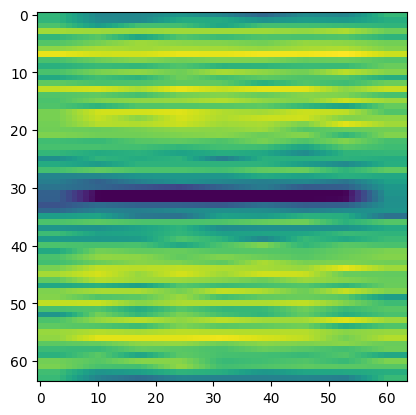

In [11]:
plt.imshow(train_data[18])

##Dataset and Siamese Dataset

In [12]:
import random
import torch
from torch.utils.data import Dataset, DataLoader

class BeeringDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [13]:
class SiameseDATA(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
        
    def __getitem__(self, index):
        # Get two random samples from the CWMR dataset
        img1, label1 = self.dataset[index]
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                img2, label2 = self.dataset[torch.randint(len(self.dataset), (1,)).item()]
                if label1 == label2:
                    break
        else:
            while True:
                img2, label2 = self.dataset[torch.randint(len(self.dataset), (1,)).item()]
                if label1 != label2:
                    break
        
        return img1, img2, torch.from_numpy(np.array([int(label1 != label2)], dtype=np.float32))

    def __len__(self):
        return len(self.dataset)

dataset = BeeringDataset(train_data, train_label)
siamese_dataset = SiameseDATA(dataset)
siamese_dataloader = DataLoader(siamese_dataset, batch_size=bs , shuffle = True)
data_loader = DataLoader(dataset, batch_size=bs , shuffle = True)
dataset_test =  BeeringDataset(test_data, test_label)
siamese_dataset_test = SiameseDATA(dataset_test)

#Before training

In [14]:
distance = nn.PairwiseDistance(p=1)
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

##Model

###Transformer Block

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MHSA(nn.Module):
    def __init__(self, n_dims, width=14, height=14, heads=4):
        super(MHSA, self).__init__()
        self.heads = heads

        self.query = nn.Conv2d(n_dims, n_dims, kernel_size=1)
        self.key = nn.Conv2d(n_dims, n_dims, kernel_size=1)
        self.value = nn.Conv2d(n_dims, n_dims, kernel_size=1)

        self.rel_h = nn.Parameter(torch.randn([1, heads, n_dims // heads, 1, height]), requires_grad=True)
        self.rel_w = nn.Parameter(torch.randn([1, heads, n_dims // heads, width, 1]), requires_grad=True)

        self.softmax = nn.Softmax(dim=-1)
        self.norm = nn.LayerNorm([n_dims, width, height])

    def forward(self, x):
        n_batch, C, width, height = x.size()
        q = self.query(x).view(n_batch, self.heads, C // self.heads, -1)
        k = self.key(x).view(n_batch, self.heads, C // self.heads, -1)
        v = self.value(x).view(n_batch, self.heads, C // self.heads, -1)

        content_content = torch.matmul(q.permute(0, 1, 3, 2), k)

        content_position = (self.rel_h + self.rel_w).view(1, self.heads, C // self.heads, -1).permute(0, 1, 3, 2)
        content_position = torch.matmul(content_position, q)

        energy = content_content + content_position
        attention = self.softmax(energy)

        out = torch.matmul(v, attention.permute(0, 1, 3, 2))
        out = out.view(n_batch, C, width, height)
        out = self.norm(out) + x
        return out

###MLP-conv

In [ ]:
!pip install einops
clear_output()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import numpy as np
from torch import nn
from einops.layers.torch import Rearrange


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class MixerBlock(nn.Module):
    def __init__(self, dim, num_patch, token_dim, channel_dim, dropout = 0.):
        super().__init__()
        
        self.token_mix = nn.Sequential(
            nn.LayerNorm(dim),
            Rearrange('b n d -> b d n'),
            FeedForward(num_patch, token_dim, dropout),
            Rearrange('b d n -> b n d')
        )
        
        self.channel_mix = nn.Sequential(
            nn.LayerNorm(dim),
            FeedForward(dim, channel_dim, dropout),
        )
    def forward(self, x):
        x = x + self.token_mix(x)
        x = x + self.channel_mix(x)
        
        
        return x


class HybridModel(nn.Module):
    def __init__(self, in_channels, dim, inner_dim, num_classes, depth, token_dim, channel_dim):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,inner_dim,kernel_size=3,padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(inner_dim),
            nn.GELU(),
            nn.Conv2d(inner_dim,dim,kernel_size=3,padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(dim),
            nn.GELU(),
            Rearrange('b c h w -> b (h w) c'),
        )
        
        self.mixer_blocks = nn.ModuleList([])
        for _ in range(depth):
            self.mixer_blocks.append(MixerBlock(dim, 256, token_dim, channel_dim))

        self.layer_norm = nn.LayerNorm(dim)
        self.linear = nn.Linear(dim, num_classes)

    def forward(self, x):
        x = self.conv(x)
        for mixer_block in self.mixer_blocks:
            x = mixer_block(x)
        x = self.layer_norm(x)
        x = x.mean(dim=1)
        x = self.linear(x)
        return x

In [ ]:
model1 = HybridModel(in_channels=1, num_classes=2, dim=256, inner_dim=128, depth=1, token_dim=512, channel_dim=512)
checking = torch.rand([1,1,64,64])
model1(checking).shape

###Proposed model

In [20]:
class convMixerLayer(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size) -> None:
        super().__init__()
        self.depthwise = nn.Conv2d(
            in_channels=in_channel, 
            out_channels=out_channel, 
            groups=in_channel, 
            kernel_size=kernel_size,
            stride=1,
            padding="same"
        )
        self.pointwise = nn.Conv2d(in_channel, out_channel, 1, 1)
        self.activation = nn.GELU()
        self.batchnorm1 = nn.BatchNorm2d(out_channel)
        self.batchnorm2 = nn.BatchNorm2d(out_channel)
        #self.trans = MHSA(n_dims = out_channel, width=64, height=64, heads=4)
    
    def forward(self, x):
        ori = x
        #x = self.trans(x)
        x = self.depthwise(x)
        x = self.activation(x)
        x = self.batchnorm1(x) + ori
        x = self.pointwise(x)
        x = self.activation(x)
        x = self.batchnorm2(x)
        return x

class SiameseNetwork(nn.Module):
    def __init__(self, patch_size = 3, kernel_size = 3, h = 64, depth = 10, num_classes = 2) -> None:
        super().__init__()
        self.depth = depth
        self.patch_embed = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=h, kernel_size=patch_size, stride=patch_size),
            nn.GELU(),
            nn.BatchNorm2d(h)
        )
        convmix = [convMixerLayer(h, h, kernel_size) for i in range(depth)]
        self.convmix = nn.Sequential(*convmix)
        self.gbpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(h, num_classes)
        #self.trans = MHSA(n_dims = h, width=21, height=21, heads=4)
    
    def forward(self, x):
        x = self.patch_embed(x)
        x = self.convmix(x)
        #---Transformer---#
        #x = self.trans(x)
        #-----------------#
        x = self.gbpool(x)
        x = x.view(x.shape[0], -1)
        x = self.linear(x)
        return x

In [21]:
model = SiameseNetwork()
#test = test_data.unsqueeze(dim = 1)
#model(test).shape

In [22]:
mean = train_data.mean()
std = train_data.std()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#To CUDA
model = model.to(device)
mean = mean.to(device)
std = std.to(device)

In [23]:
from torchsummary import summary
summary(model, input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 21, 21]             640
              GELU-2           [-1, 64, 21, 21]               0
       BatchNorm2d-3           [-1, 64, 21, 21]             128
            Conv2d-4           [-1, 64, 21, 21]             640
              GELU-5           [-1, 64, 21, 21]               0
       BatchNorm2d-6           [-1, 64, 21, 21]             128
            Conv2d-7           [-1, 64, 21, 21]           4,160
              GELU-8           [-1, 64, 21, 21]               0
       BatchNorm2d-9           [-1, 64, 21, 21]             128
   convMixerLayer-10           [-1, 64, 21, 21]               0
           Conv2d-11           [-1, 64, 21, 21]             640
             GELU-12           [-1, 64, 21, 21]               0
      BatchNorm2d-13           [-1, 64, 21, 21]             128
           Conv2d-14           [-1, 64,

#Training

In [24]:
def Train(model, criterion, optimizer, siamese_dataloader, device, mean, std):
    model.train()
    running_loss=0
    num_batches=0
    for i, data in enumerate(siamese_dataloader, 0):
        img1, img2 , label = data
        img1 = img1.unsqueeze(dim=1)
        img2 = img2.unsqueeze(dim=1)
        img1 = img1.to(device)
        img2 = img2.to(device)
        img1 = (img1 - mean)/std
        img2 = (img2 - mean)/std
        label = label.to(device)
        optimizer.zero_grad()
        output1 = model(img1)
        output2 = model(img2)
        distance_score = distance(output1, output2)
        distance_score = distance_score.unsqueeze(dim=1)
        ##---------Using constrastive loss------#
        loss = criterion(output1, output2, label)
        #---------Using casual loss------------#
        #loss = criterion(distance_score, label)
        loss.backward()
        optimizer.step()
        loss_detech = loss.detach().item()
        running_loss += loss_detech
        num_batches += 1
        #---Compute average loss per batchsize----#
        loss_bs = running_loss/num_batches
    return loss_bs


In [25]:
siamese_dataloader_check = DataLoader(siamese_dataset, batch_size=1, shuffle=True)
siamese_dataloader_test = DataLoader(siamese_dataset_test, batch_size=1, shuffle=False)
def On_Testset(model, siamese_dataloader_test, mean, std, device):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(siamese_dataloader_test):
            img1, img2, label = data
            img1 = img1.unsqueeze(dim=1)
            img2 = img2.unsqueeze(dim=1)
            img1 = img1.to(device)
            img2 = img2.to(device)
            img1 = (img1 - mean)/std
            img2 = (img2 - mean)/std
            label = label.to(device)
            output1 = model(img1)
            output2 = model(img2)
            #output1, output2 = model(img1, img2)
            euclidean_distance = distance(output1, output2)
            if (euclidean_distance < 0.5):
              predictions = 0
            else:
              predictions = 1
            #predictions = torch.lt(euclidean_distance, 0.5).tolist()
            total += label.size(0)
            correct += sum(np.array(predictions) == label.tolist())
        accuracy = (correct / total)
    return accuracy.item()

In [26]:
criterion = ContrastiveLoss()
#criterion = nn.MSELoss()
#criterion = nn.BCEWithLogitsLoss()
lr = 0.001
from torch.optim import Adam
# Define the loss function and optimizer
full_loss=[]
start=time.time()
the_best_acc = 0
acc_test = []
# train the model
for epoch in range(1,200):
    optimizer = Adam(model.parameters(), lr=lr, )  
    loss_bs = Train(model, criterion, optimizer, siamese_dataloader, device, mean, std)
    acc = On_Testset(model, siamese_dataloader_test, mean, std, device)

    #----Stored loss, accuracy per epoch-----#
    acc_test.append(acc)
    elapsed = (time.time()-start)/60
    full_loss.append(loss_bs)
    print('epoch=',epoch, '\t time={:.5f} min'.format(elapsed),'\t loss={:.5f}'.format(loss_bs), '\t Accuracy on Test set = {:.5f}'.format(acc))
    #---------Save the best model------------#
    if acc > the_best_acc:
        the_best_acc = acc
        print("==> This is the best model with Accuracy on test set is {:.5f}".format(acc))
        #save if needed
        data_path='/content/drive/MyDrive/Python/'
        torch.save(model,data_path+'DataBearing/best_model.pt')
    torch.cuda.empty_cache()
print("Training completed")

epoch= 1 	 time=0.10322 min 	 loss=1.14911 	 Accuracy on Test set = 0.46667
==> This is the best model with Accuracy on test set is 0.46667
epoch= 2 	 time=0.19400 min 	 loss=0.49996 	 Accuracy on Test set = 0.51600
==> This is the best model with Accuracy on test set is 0.51600
epoch= 3 	 time=0.26741 min 	 loss=0.55170 	 Accuracy on Test set = 0.84667
==> This is the best model with Accuracy on test set is 0.84667
epoch= 4 	 time=0.35650 min 	 loss=0.36384 	 Accuracy on Test set = 0.82933
epoch= 5 	 time=0.42764 min 	 loss=0.36238 	 Accuracy on Test set = 0.73600
epoch= 6 	 time=0.49936 min 	 loss=0.24642 	 Accuracy on Test set = 0.76267
epoch= 7 	 time=0.58872 min 	 loss=0.40577 	 Accuracy on Test set = 0.83867
epoch= 8 	 time=0.66272 min 	 loss=0.34106 	 Accuracy on Test set = 0.78933
epoch= 9 	 time=0.73353 min 	 loss=0.31131 	 Accuracy on Test set = 0.89333
==> This is the best model with Accuracy on test set is 0.89333
epoch= 10 	 time=0.82319 min 	 loss=0.31768 	 Accuracy on Te

In [27]:
#-----Load the best model------#
data_path='/content/drive/MyDrive/Python/'
model = torch.load(data_path+'DataBearing/best_model.pt')
#--accuracy of the best model--#
On_Testset(model, siamese_dataloader_test, mean, std, device)

0.8933333333333333

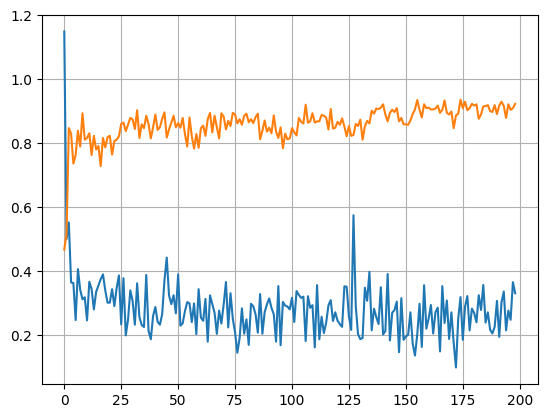

In [28]:
import csv
plt.plot(full_loss)
#plt.legend("Train loss")
plt.plot(acc_test)
#plt.legend('Test accuracy')
plt.grid(True)
plt.show()

loss_list = full_loss
full_loss_path ='/content/drive/MyDrive/Python/DataBearing/mlp_siamese_spectrograminput_LOSS.csv'
with open(full_loss_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows([[loss] for loss in loss_list])

In [ ]:
model.cpu()

In [ ]:
import h5py
with h5py.File('model.h5', 'w') as f:
    for name, param in model.named_parameters():
        f.create_dataset(name, data=param.detach().numpy())

##Test output of Siamese with groundtruth is choosing 0.5

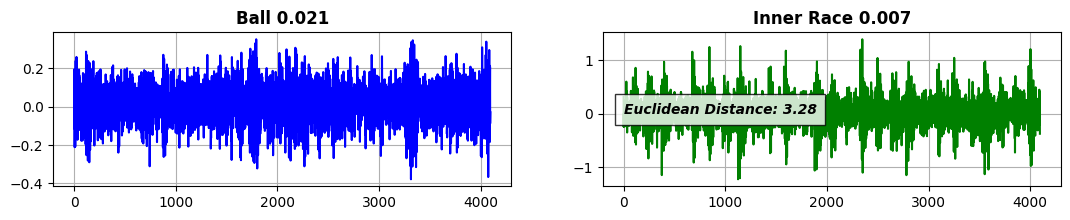

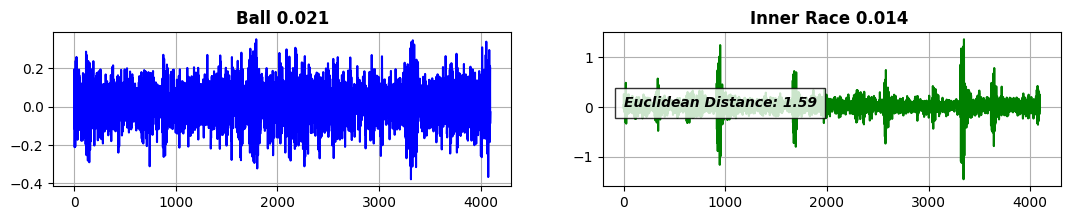

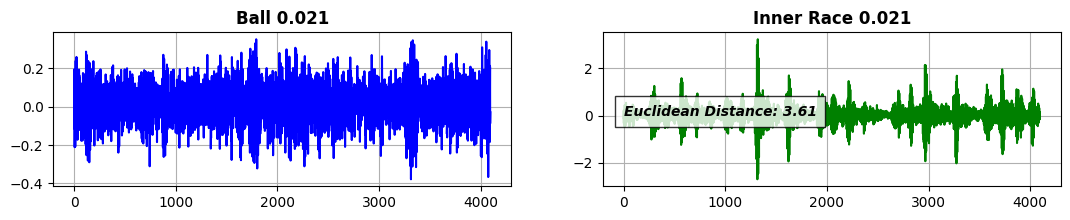

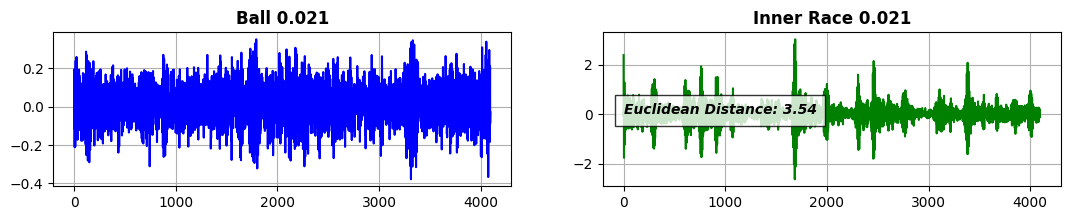

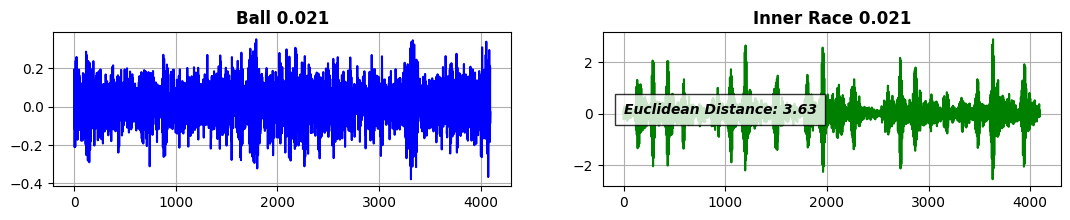

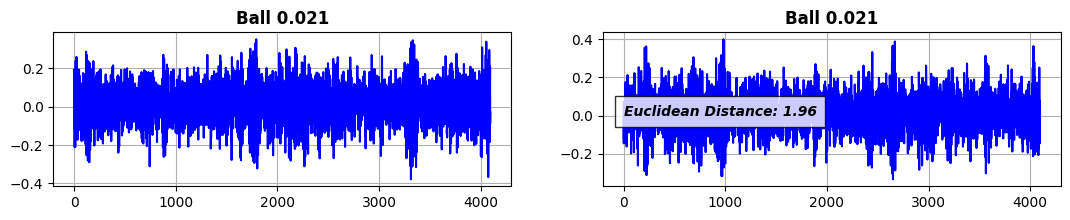

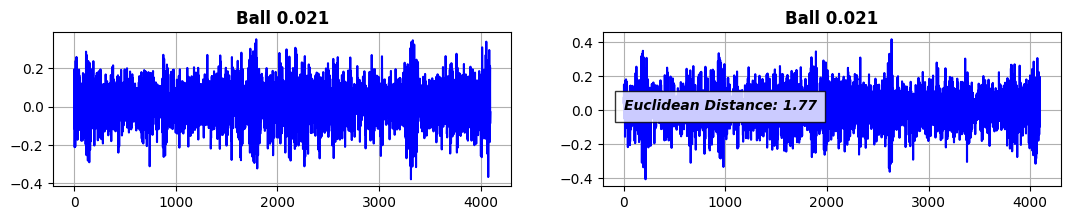

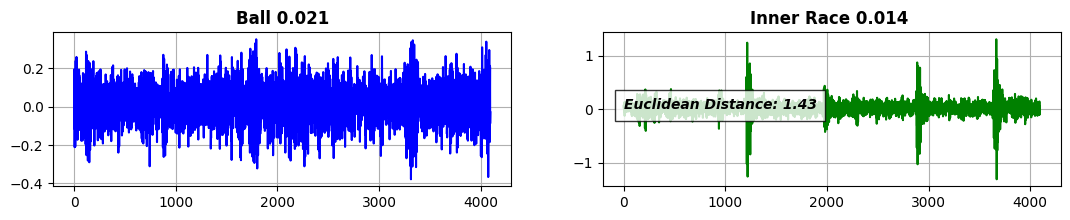

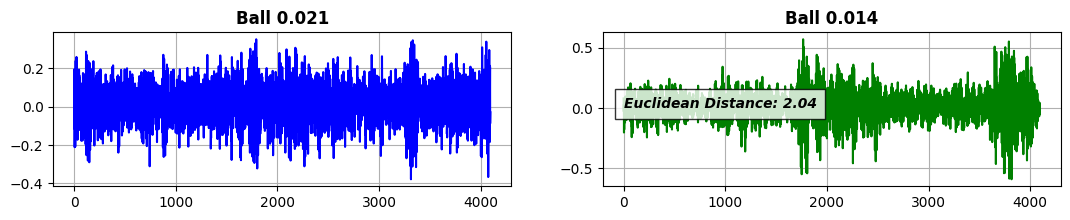

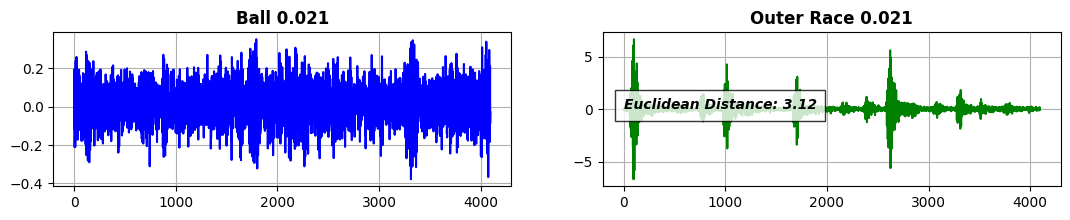

In [29]:
#Choose 1 signal and compare with other 10 signals
model.eval()
model = model.to(device)
map_label = {0:"None",1:"Ball 0.007",2:"Ball 0.014",3:"Ball 0.021",4:"Inner Race 0.007",
             5:"Inner Race 0.014 ",6:"Inner Race 0.021",7:"Outer Race 0.007",8:"Outer Race 0.014",9:"Outer Race 0.021"}
idx = randint(0, 750-1)
x0, label1 = dataset_test[5]
x0 = x0.to(device)
x0 = (x0 - mean)/std
x0_bf = test_data_bf_spec[idx]
for i in range(10):
    idx1 = randint(0, 750-1)
    x1_bf = test_data_bf_spec[i+10]
    plt.rcParams['figure.figsize'] = [13, 2]
    x1, label2 = dataset_test[i+10]
    x1 = x1.to(device)
    x1 = (x1 -mean)/std
    plt.figure(i)
    plt.subplot(1,2,1)
    plt.plot(x0_bf, color = 'blue')
    if(label1 == label2):
      plt.title("{}".format(map_label[label1.item()]),fontweight='bold')
      plt.grid()
      plt.subplot(1,2,2)
      plt.plot(x1_bf, color = 'blue')
      plt.grid()
      plt.title("{}".format(map_label[label2.item()]),fontweight='bold')
      x0 = x0.view([1,1,64,64])
      x1 = x1.view([1,1,64,64])
      output1 = model(x0)
      output2 = model(x1)
      #output1, output2 = model(x0, x1)
      euclidean_distance = distance(output1, output2)
      #print(euclidean_distance)
      plt.text(0, 0, f'Euclidean Distance: {euclidean_distance.item():.2f}', style='oblique',fontweight='bold',bbox={'facecolor':'white', 'alpha':0.8, 'pad':6})
    else:
      plt.title("{}".format(map_label[label1.item()]),fontweight='bold')
      plt.grid()
      plt.subplot(1,2,2)
      plt.plot(x1_bf, color = 'g')
      plt.grid()
      plt.title("{}".format(map_label[label2.item()]),fontweight='bold')
      x0 = x0.view([1,1,64,64])
      x1 = x1.view([1,1,64,64])
      output1 = model(x0)
      output2 = model(x1)
      #output1, output2 = model(x0, x1)
      euclidean_distance = distance(output1, output2)
      #print(euclidean_distance)
      plt.text(0, 0, f'Euclidean Distance: {euclidean_distance.item():.2f}', style='oblique',fontweight='bold',bbox={'facecolor':'white', 'alpha':0.8, 'pad':6})

#Few-shot learning

In [30]:
import random
num_shots = 5
few_shot_examples = {i: [] for i in range(10)}
for images, labels in dataset:
    label = labels.item()
    if len(few_shot_examples[label]) < num_shots:
        few_shot_examples[label].append(images)
    else:
        continue

few_shot_examples = [(example, label) for label, examples in few_shot_examples.items() for example in examples]

In [31]:
#---------------Output of few-shot learning------------------------------------#


def fewshot_learning_return(x_train, few_shot_examples, mean, std, net, numshots):
  x_train = x_train.to(device)
  x_train = (x_train - mean)/std
  x_train = x_train.unsqueeze(dim=0).unsqueeze(dim=0)
  output = torch.zeros((10))
  #output = np.zeros((10,1))
  scores = 0
  count = 0
  idx = 0
  for example, target in few_shot_examples:
    example = example.unsqueeze(dim=0).unsqueeze(dim=0)
    example = example.to(device)
    example = (example - mean)/std
    net = net.to(device)
    out1 = net(x_train)
    out2 = net(example)
    score = distance(out1, out2)
    with torch.no_grad():
      scores += score
      count += 1
      if (count  % numshots == 0):
        output[idx] = scores/numshots
        scores = 0
        idx += 1
    output.detach().cpu()
    output1 = output/output.sum()        
  return output1

In [32]:
#--------Check faults------------#

def Check_faults(input , few_shot_examples, mean, std, numshots = 5):
    map_label = {0:"None",1:"Ball 0.007",2:"Ball 0.014",3:"Ball 0.021",4:"Inner Race 0.007",
             5:"Inner Race 0.014 ",6:"Inner Race 0.021",7:"Outer Race 0.007",8:"Outer Race 0.014",9:"Outer Race 0.021"}
    faults = np.argmin(fewshot_learning_return(input, few_shot_examples, mean, std, model, numshots))

    return map_label[faults.item()]

In [33]:
test_label.shape[0]

750

In [34]:
from torch import randint
i = random_int = torch.randint(low=0, high=750, size=())

test = test_data[i.item()]
print(map_label[test_label[i].item()])
Check_faults(test , few_shot_examples, mean, std)

Inner Race 0.014 


'Inner Race 0.014 '

In [35]:
import csv
output_net = torch.zeros([750,10])
for i in range(len(test_label)):
  output_net[i]= fewshot_learning_return(test_data[i], few_shot_examples, mean, std, model.eval(), 5)
#-----Save to csv----------#
data_list = output_net.tolist()
output_file ='/content/drive/MyDrive/Python/DataBearing/output_net_spectrogram.csv'
with open(output_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(data_list)

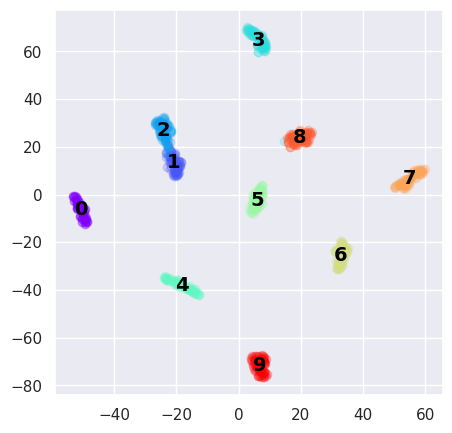

In [36]:
#Load output 

#Plot with labels
from keras import backend as K
import numpy as np
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
plot_only = len(test_label)
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_dim_embs = tsne.fit_transform(output_net)
p_data = pd.DataFrame(columns=['x', 'y', 'label'])
p_data.x = low_dim_embs[:, 0]
p_data.y = low_dim_embs[:, 1]
p_data.label = test_label[0:plot_only]
utils.plot_with_labels(p_data)

In [37]:
pred = torch.rand([750])
pred = pred.reshape(-1,1)
for i in range(len(test_label)):
  pred[i] = np.argmin(fewshot_learning_return(test_data[i], few_shot_examples, mean, std, model.eval(), 5))
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix
utils.plot_confusion_matrix(confusion_matrix(test_label,pred),  normalize=False)

Confusion matrix, without normalization
[[75  0  0  0  0  0  0  0  0  0]
 [ 0 71  4  0  0  0  0  0  0  0]
 [ 0  5 70  0  0  0  0  0  0  0]
 [ 0  0  0 74  0  0  0  0  1  0]
 [ 0  0  0  0 75  0  0  0  0  0]
 [ 0  0  0  0  0 75  0  0  0  0]
 [ 0  0  0  0  0  0 75  0  0  0]
 [ 0  0  0  0  0  0  0 75  0  0]
 [ 0  0  0  0  0  0  0  0 75  0]
 [ 0  0  0  0  0  0  0  0  0 75]]


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [38]:
matrix = confusion_matrix(test_label,pred)
TL = 0
for i in range(matrix.shape[0]):
    TL += confusion_matrix(test_label,pred)[i][i]
print('Accuracy: {:.2f}'.format(TL/test_label.shape[0]))

Accuracy: 0.99
